In [8]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import DataLoader,Dataset,random_split

In [9]:
tr_df = pd.DataFrame(columns=["img_name","Label"])
tr_df["img_name"] = os.listdir(r"C:\Users\Ajay shankar\Downloads\train")
for idx,i in enumerate(os.listdir(r"C:\Users\Ajay shankar\Downloads\train")):
    if "cat" in i:
        tr_df.at[idx,"Label"] = 0
    if "dog" in i:
        tr_df.at[idx,"Label"] = 1

tr_df.to_csv(r'tr_csv.csv',index = False,header = True)

In [10]:
print(tr_df)

           img_name Label
0         cat.0.jpg     0
1         cat.1.jpg     0
2        cat.10.jpg     0
3       cat.100.jpg     0
4      cat.1000.jpg     0
...             ...   ...
25581    dog_92.jpg     1
25582    dog_93.jpg     1
25583    dog_97.jpg     1
25584    dog_98.jpg     1
25585    dog_99.jpg     1

[25586 rows x 2 columns]


In [11]:
class customdataset(Dataset):
    def __init__(self,root_dir,csv_file,transform=None):
        self.root_dir = root_dir
        self.img_file = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.img_file)
    
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,self.img_file.iloc[idx,0])
        image = Image.open(img_name)
        Label = self.img_file.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        return image,Label
    


In [12]:
all_transform = transform.Compose([
    transform.Resize((64, 64)),  # Adjust this size to match your model's expected input
    transform.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [13]:
b_size=32
n_classes=2
lr=0.007
num_epochs=10

In [14]:
f_dataset = customdataset(root_dir=r"C:\Users\Ajay shankar\Downloads\train",csv_file='tr_csv.csv',transform=all_transform)
train_s = int(0.7 * len(f_dataset))
test_s = int(0.2 * len(f_dataset))
validate_s = int(len(f_dataset)) - train_s - test_s

In [15]:
train_dataset,test_dataset,validate_dataset = random_split(f_dataset,[train_s,test_s,validate_s])

In [16]:
train_loader = DataLoader(dataset=train_dataset,batch_size=b_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=b_size,shuffle=True)
validate_loader = DataLoader(dataset=validate_dataset,batch_size=b_size,shuffle=True)

In [17]:
class CNN(nn.Module):
    def __init__(self,n_classes):
        super(CNN, self).__init__()
        self.cl1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
        self.cl2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.cl3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.cl4 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)

        

        self.fc1 = nn.Linear(10816,128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128,128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128,n_classes)

    def forward(self,x):
        out = self.cl1(x)
        out = self.cl2(out)
        out = self.maxpool1(out)

        out = self.cl3(out)
        out = self.cl4(out)
        out = self.maxpool2(out)

        

        out = out.reshape(out.size(0),-1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        
        return out

In [18]:
model = CNN(n_classes)
model.load_state_dict(torch.load("catvsdog.pth"))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=0.005,momentum=0.9)

In [19]:
torch.save(model.state_dict(),'catvsdog.pth')

In [20]:
model = CNN(n_classes)
model.load_state_dict(torch.load("catvsdog.pth"))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=0.005,momentum=0.9)

In [21]:
for inputs, label in train_loader:
    print(inputs.shape)  # Check this before passing to the model
    break


torch.Size([32, 3, 64, 64])


In [22]:
for epoch in range(num_epochs):
    model.train()
    for inputs,label in train_loader:
        pred = model(inputs)
        loss = criterion(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    acc = 0
    count = 0
    with torch.no_grad():
        for inputs,label in test_loader:
            pred = model(inputs)
            acc += (torch.argmax(pred,1) == label).float().sum()
            count += len(label)
    acc /= count
    print(f"Epoch {epoch + 1}: model accuracy {acc*100:.4f}%")

Epoch 1: model accuracy 88.8802%
Epoch 2: model accuracy 86.1833%
Epoch 3: model accuracy 85.1866%
Epoch 4: model accuracy 83.8186%
Epoch 5: model accuracy 82.3529%
Epoch 6: model accuracy 80.9068%
Epoch 7: model accuracy 80.2814%
Epoch 8: model accuracy 79.7928%
Epoch 9: model accuracy 79.3043%
Epoch 10: model accuracy 79.2652%


In [23]:
model.eval()
v_acc = 0
v_count = 0
with torch.no_grad():
    for inputs,label in validate_loader:
        pred = model(inputs)
        v_acc += (torch.argmax(pred,1) == label).float().sum()
        v_count += len(label)
v_acc /= v_count
print(f"Validation accuracy {v_acc*100:.4f}%")

Validation accuracy 80.2267%


In [24]:
torch.save(model.state_dict(),'catvsdog.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.88235295].


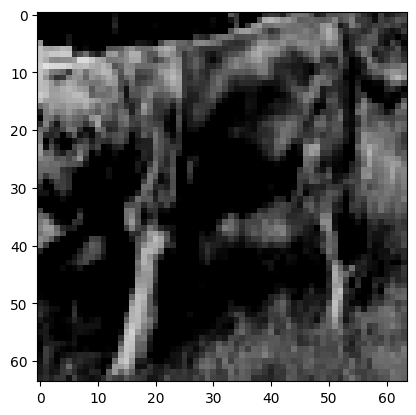

In [32]:
sample_image, _ = train_dataset[150]
plt.imshow(sample_image.permute(1, 2, -0).numpy()) 
plt.show()

In [26]:
import torch

# Define your model architecture (make sure CNN is properly defined)
model = CNN(n_classes)  
model.load_state_dict(torch.load("catvsdog.pth"))  
model.eval()  # Set to evaluation mode

# Create a dummy input tensor (batch size 1, 3 color channels, 32x32 image)
dummy_input = torch.randn(1, 3, 64, 64)

# Export the model to ONNX format
torch.onnx.export(model, dummy_input, "catvsdog.onnx", 
                  input_names=["input"], output_names=["output"], 
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})

print("Model successfully converted to ONNX format: catvsdog.onnx")


Model successfully converted to ONNX format: catvsdog.onnx


In [27]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
session = ort.InferenceSession("catvsdog.onnx")

# Get model input details
input_name = session.get_inputs()[0].name

# Create a dummy input (batch size 1, 3 color channels, 32x32 image)
dummy_input = np.random.randn(1, 3, 64, 64).astype(np.float32)

# Run inference
outputs = session.run(None, {input_name: dummy_input})

# Print output
print("Model Output:", outputs[0])


Model Output: [[-6.835502  6.829153]]


In [28]:
import torch.nn.functional as F
probabilities = F.softmax(torch.tensor(outputs[0]), dim=1).numpy()
print("Probabilities:", probabilities)


Probabilities: [[1.1628265e-06 9.9999881e-01]]
